### To Do : ---

In [1]:
import pandas as pd
import os
import matplotlib
%matplotlib inline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sb

import warnings
warnings.filterwarnings("ignore")


In [2]:
# for dirname, _, filenames in os.walk('/mnt/'):
#     for filename in filenames:
#         print(os.path.join(dirname,filename))

In [3]:
train_data = pd.read_csv('/mnt/cs-training.csv')

In [4]:
train_data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
train_data_input = train_data.loc[:,~train_data.columns.isin(['Unnamed: 0','SeriousDlqin2yrs'])]

In [6]:
train_data_input.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
train_data_output = train_data[['SeriousDlqin2yrs']]

In [8]:
train_data_output.head()

,SeriousDlqin2yrs
0,1
1,0
2,0
3,0
4,0


In [9]:
train_data_input.shape

(150000, 10)

In [10]:
train_data_output.shape

(150000, 1)

In [11]:
# Listing all input features

for feature in train_data_input.columns:
    print(feature)

RevolvingUtilizationOfUnsecuredLines
age
NumberOfTime30-59DaysPastDueNotWorse
DebtRatio
MonthlyIncome
NumberOfOpenCreditLinesAndLoans
NumberOfTimes90DaysLate
NumberRealEstateLoansOrLines
NumberOfTime60-89DaysPastDueNotWorse
NumberOfDependents


## Data Exploration

### Exploring Output Data

In [12]:
output_stat = Counter(train_data_output.SeriousDlqin2yrs)

In [13]:
print("Percentage of Customers who default are: "+str(round(output_stat[1]*100/(output_stat[0]+output_stat[1]),2))+"%")

Percentage of Customers who default are: 6.68%


In [14]:
print("Percentage of Customers who do not default are: "+str(round(output_stat[0]*100/(output_stat[0]+output_stat[1]),2))+"%")


Percentage of Customers who do not default are: 93.32%


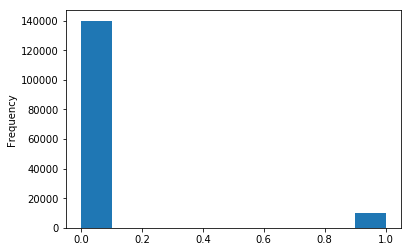

In [15]:
train_data_output['SeriousDlqin2yrs'].plot.hist()

In [16]:
#Note: the data above is an example of class imbalance having the ration of 7:93
## Generally there are two approaches to handle class imbalance:
## a. sampling based
## b. cost based 

# Lets read through this on Class imbalance: 
## https://machinelearningmastery.com/what-is-imbalanced-classification/
## https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23

### Exploring Input Features

#### RevolvingUtilizationOfUnsecuredLines

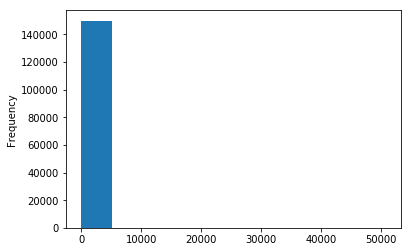

In [17]:
train_data_input['RevolvingUtilizationOfUnsecuredLines'].plot.hist()

In [18]:
train_data['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

#### Detecting whether RevolvingUtilizationOfUnsecuredLines has outliers

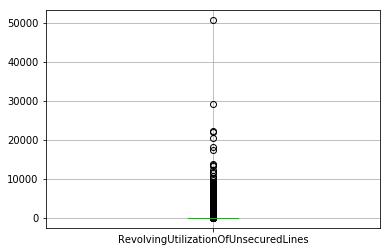

In [19]:
# Indentifying if ReveolvingUtilizationOfUnsecuredLines has any otliers
## Link on article about Outlier detection: https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/

#Approach 1: Extreme Value Analysis
# https://heartbeat.fritz.ai/how-to-make-your-machine-learning-models-robust-to-outliers-44d404067d07
## Interquartile range is given by, IQR = Q3 — Q1 
## Upper limit = Q3+1.5*IQR 
## Lower limit = Q1–1.5*IQR 
## Anything below the lower limit and above the upper limit is considered an outlier
## Note: Linear models are more impacted by the outliers than the tree based models. Source: https://www.quora.com/Why-are-tree-based-models-robust-to-outliers

train_data_input[['RevolvingUtilizationOfUnsecuredLines']].boxplot()

In [20]:
q_1 = train_data['RevolvingUtilizationOfUnsecuredLines'].describe()['25%']
q_3 = train_data['RevolvingUtilizationOfUnsecuredLines'].describe()['75%']
inter_quartile_range =  round(q_3 - q_1,2)
upper_limit_outlier = round(q_3 + 1.5*inter_quartile_range,2)
lower_limit_outlier = round(q_3 - 1.5*inter_quartile_range,2)

In [21]:
inter_quartile_range, lower_limit_outlier, upper_limit_outlier

(0.53, -0.24, 1.35)

In [22]:
outlier_count = 0
lower_outliers, upper_outliers = 0,0
for i in train_data_input['RevolvingUtilizationOfUnsecuredLines']:
    if i > upper_limit_outlier:
        upper_outliers+=1 
        outlier_count+=1
    if i < lower_limit_outlier:
        lower_outliers+=1
        outlier_count+=1


print("Percentage datapoints of RevolvingUtilizationOfUnsecuredLines that are outliers is "+str(outlier_count*100/len(train_data_input['RevolvingUtilizationOfUnsecuredLines']))+"%")


Percentage datapoints of RevolvingUtilizationOfUnsecuredLines that are outliers is 0.51%


In [23]:
print(upper_outliers,lower_outliers)

765 0


#### Handling outliers of RevolvingUtilizationOfUnsecuredLines

In [24]:
# How to deal with these outliers? Should they be removed, imputed, etc?
## Currently we are imputing the outliers with values, 
## upper_outliers will be imputed with the maximum value that falls under upper_limit_outlier
## lower_outliers will be imputed with the minimum value that falls under lower_limit_outlier

In [25]:
valid_upper_val = train_data_input[train_data_input['RevolvingUtilizationOfUnsecuredLines'] < upper_limit_outlier]['RevolvingUtilizationOfUnsecuredLines'].max()
valid_lower_val = train_data_input[train_data_input['RevolvingUtilizationOfUnsecuredLines'] > lower_limit_outlier]['RevolvingUtilizationOfUnsecuredLines'].min()



In [26]:
valid_upper_val,valid_lower_val

(1.349255721, 0.0)

In [27]:
train_data_input.loc[train_data_input['RevolvingUtilizationOfUnsecuredLines']>upper_limit_outlier,'RevolvingUtilizationOfUnsecuredLines']=valid_upper_val
train_data_input.loc[train_data_input['RevolvingUtilizationOfUnsecuredLines']<lower_limit_outlier,'RevolvingUtilizationOfUnsecuredLines']=valid_lower_val


In [28]:
#### Confirming that outliers of RevolvingUtilizationOfUnsecuredLines has been handled

In [29]:
outlier_count = 0
lower_outliers, upper_outliers = 0,0
for i in train_data_input['RevolvingUtilizationOfUnsecuredLines']:
    if i > upper_limit_outlier:
        upper_outliers+=1 
        outlier_count+=1
    if i < lower_limit_outlier:
        lower_outliers+=1
        outlier_count+=1


print(upper_outliers,lower_outliers,"Percentage datapoints of RevolvingUtilizationOfUnsecuredLines that are outliers is "+str(outlier_count*100/len(train_data_input['RevolvingUtilizationOfUnsecuredLines']))+"%")


0 0 Percentage datapoints of RevolvingUtilizationOfUnsecuredLines that are outliers is 0.0%


#### age

In [30]:
train_data_input['age'].describe()

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

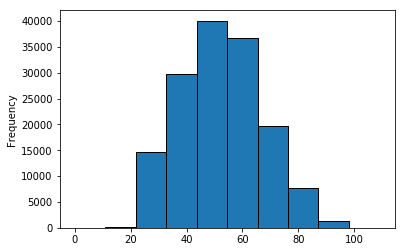

In [31]:
train_data_input['age'].plot.hist(edgecolor='black')

In [32]:
# options are: outlier, bin or adaptive_bin
age_bin_or_outlier = 'adaptive_bin'

#### Experimenting with Fixed Width Binning for age column
##### Note: While runing binning, do not run the outlier code of the age so that we are able to identify the affaect of the two independently

In [33]:
# Fixed with Binning: Source, https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b#:~:text=Binning%2C%20also%20known%20as%20quantization,are%20binned%20or%20grouped%20into.

if age_bin_or_outlier == 'bin':

    train_data_input['age_fixed_width_bin'] = np.where(train_data_input['age'] <= 25, 1,
                                            np.where(train_data_input['age'] <= 35, 2,
                                            np.where(train_data_input['age'] <= 45, 3,
                                            np.where(train_data_input['age'] <= 55, 4,
                                            np.where(train_data_input['age'] <= 65, 5,
                                            np.where(train_data_input['age'] <= 75, 6,
                                            np.where(train_data_input['age'] <= 85, 7,
                                            np.where(train_data_input['age'] <= 95, 8,9))))))))
    
    print(set(train_data_input['age_fixed_width_bin']))
    
    train_data_input['age'] = train_data_input['age_fixed_width_bin']
    
    train_data_input.drop(columns='age_fixed_width_bin',inplace=True)

#### Experimenting with Adaptive Binning for age column

##### Concept behind Adaptive Binning:     In Fixed-Width-Binning we manually create the threshold for the bins. In Adaptive based we look at distribution of the data to create the bins.

In [34]:
if age_bin_or_outlier == 'adaptive_bin':

    quantiles = 10 # Example: if quantiles = 4, it means, bins will be 0-25 percentile, 25-50th percentile, 50-75th percentile and 75-100th percentile
    quantile_label = [i for i in range(quantiles)]
    train_data_input['age_adaptive_bin'] = pd.qcut(train_data_input['age'],
                                                   q=quantiles,
                                                   labels=quantile_label)

    print(set(train_data_input['age_adaptive_bin']))

    train_data_input['age'] = train_data_input['age_adaptive_bin']

    train_data_input.drop(columns='age_adaptive_bin',inplace=True)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


#### Detecting outliers for age

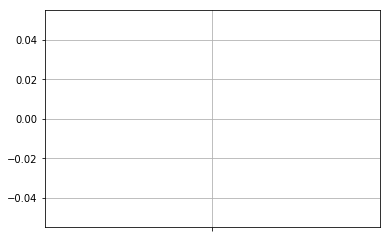

In [35]:
train_data_input[['age']].boxplot()

In [36]:
if age_bin_or_outlier == 'outlier':

    percent_75_age = train_data_input['age'].describe()['75%']
    percent_25_age = train_data_input['age'].describe()['25%']
    iqr = percent_75_age - percent_25_age
    valid_upper_range = percent_75_age + 1.5*iqr
    valid_lower_range = percent_25_age - 1.5*iqr

    print(valid_upper_range,valid_lower_range)

In [37]:
if age_bin_or_outlier == 'outlier':
    outlier_count = 0
    for age in train_data_input['age']:
        if age > valid_upper_range or age < valid_lower_range:
            outlier_count+=1

    print(outlier_count, "Percentage of outliers in age are "+str(round(outlier_count*100/train_data_input['age'].count(),2))+"%")

#### Handling outliers for age

In [38]:
if age_bin_or_outlier == 'outlier':
    max_valid_age = train_data_input[train_data_input['age']<valid_upper_range]['age'].max()
    min_valid_age = train_data_input[train_data_input['age']>valid_lower_range]['age'].min()
    print(max_valid_age,min_valid_age)

In [39]:
if age_bin_or_outlier == 'outlier':
    train_data_input.loc[train_data_input['age'] > valid_upper_range,'age']=max_valid_age
    train_data_input.loc[train_data_input['age'] < valid_lower_range,'age']=min_valid_age

#### Exploring three relevant seeming PastDue features together

#### NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate


In [40]:
due_30_59 = 'NumberOfTime30-59DaysPastDueNotWorse'
due_60_89 = 'NumberOfTime60-89DaysPastDueNotWorse'
due_90 = 'NumberOfTimes90DaysLate'

option = due_30_59

In [41]:
train_data_input[option].describe()

count    150000.000000
mean          0.421033
std           4.192781
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64

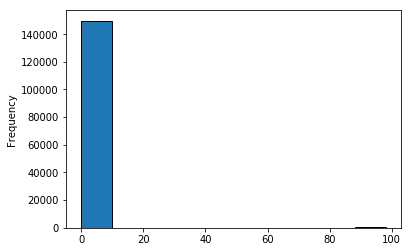

In [42]:
train_data_input[option].plot.hist(edgecolor='black')

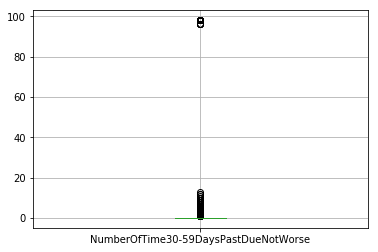

In [43]:
train_data_input[[option]].boxplot()

In [44]:
count=0
due_list = []
for due_frequency in train_data_input[option]:
    if due_frequency > 0:
        count+=1
        due_list.append(due_frequency)
        
print(sorted(Counter(due_list).items()))

[(1, 16033), (2, 4598), (3, 1754), (4, 747), (5, 342), (6, 140), (7, 54), (8, 25), (9, 12), (10, 4), (11, 1), (12, 2), (13, 1), (96, 5), (98, 264)]


#### Visualizing correlation among three features

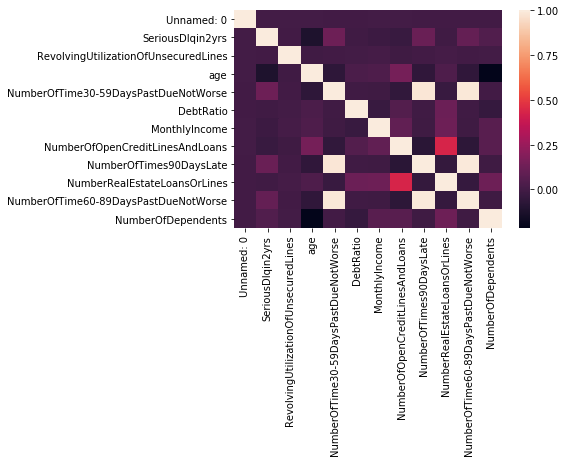

In [45]:
# Using Pearson corrleation:
# Source A : https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
# Source B :  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

correlated_matrix = train_data.corr()
sb.heatmap(correlated_matrix)

In [46]:
# Description of the above heatmap:
## a. Correlation values closer to 1 imply strong positive correlation. That is increase ... 
##    ... of value in one feature correspond to the increase of value in another feature and vice-versa.
## b. Correlation values closer to -1 imply strong negative correlation. That is increase ... 
##    ... of value in one feature correspond to the decrease of value in another feature and vice-versa.
## c. Correlation values closer to 0 imply weak correlation. Value of exact 0 implies no correlation at all.

## From the above heatmap we can see that the three below listed features are highly correlated:
## i. 'NumberOfTime30-59DaysPastDueNotWorse'
## ii. 'NumberOfTime60-89DaysPastDueNotWorse'
## iii. 'NumberOfTimes90DaysLate'

## And as we see below that their pairwise correlation is on the high end of 0.98 indicating ...
## very strong positive correlation


#### Two approach for the correlated features

In [47]:
## Approach 1: Retain only one feature and drop the other two
## In theory given that the three features are so highly correlated that they all might not be adding value ...
## ... so we can remove the other correlated features

## Lets say we maintain 'NumberOfTime30-59DaysPastDueNotWorse' and drop the other two:
train_data_input.drop(columns=['NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'],inplace=True)

## Doing so we see the Recall and Precision reduces significantly. The same is the case when we keep any one of ...
## ... the three and drop other two. Same happens if we keep any two and drop the other one.
## This shows that eventhough the features are highly correlated the model is finding all of them useful ...
## ... in making the predictions. Hence, we would not be able to drop any of the three feature


In [48]:
# one_day = 1
# one_week = 7*one_day
# half_month = 2*one_week
# one_month = 4*one_week

# custom_threshold = {0:0,one_week:1,half_month:2, one_month:3}
# #defining custom threshod for customers who were not delayed, delayed by a week, two week, one month, more than one month
    

In [49]:
# custom_threshold

In [50]:
# for past_due_feature in ['NumberOfTime60-89DaysPastDueNotWorse',
#                          'NumberOfTimes90DaysLate',
#                          'NumberOfTime30-59DaysPastDueNotWorse']:
    
#     train_data_input[past_due_feature] = np.where(train_data_input[past_due_feature]>one_month,
#                                                   custom_threshold[one_month]+1, 
#                                                   np.where(train_data_input[past_due_feature]>half_month,
#                                                            custom_threshold[half_month]+1, 
#                                                            np.where(train_data_input[past_due_feature]>one_week, 
#                                                                     custom_threshold[one_week]+1, 
#                                                                     np.where(train_data_input[past_due_feature]>0, 
#                                                                              custom_threshold[0]+1,0))))
    
#     print(sorted(Counter(train_data_input[past_due_feature]).items()))



## Build Logistic Regression Model

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


model = LogisticRegression()

In [52]:
# train_data_input.fillna(value=0,inplace=True) was throwing `ValueError: fill value must be in categories`
# What it means is that 0 is not already present in the columns having null values, this can be because the column 
# can be of different data type eg. string, float or so 

# We can overcome this error in two ways:
# Approach 1. Add np.nan as a category in the columns: Source (https://stackoverflow.com/questions/53664948/pandas-fillna-throws-valueerror-fill-value-must-be-in-categories)
# for column_having_nan_value in train_data_input.columns[train_data_input.isna().any()]:
#     print(type(column_having_nan_value))
#     train_data_input[column_having_nan_value] = train_data_input[column_having_nan_value].astype('category').cat.add_categories(0)
#     train_data_input[column_having_nan_value].fillna(0,inplace=True)
# Finding columns with nan values: Source (https://datatofish.com/columns-nan-pandas-dataframe/)
# But the approach 1 did not worked because of categories related error

#Approach 2: Use replace instead of fillna
train_data_input.replace(np.nan,0,inplace=True)




In [53]:
model.fit(train_data_input,train_data_output)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
predicted_output = model.predict(train_data_input)

In [55]:
print(classification_report(train_data_output['SeriousDlqin2yrs'],predicted_output))

             precision    recall  f1-score   support

          0       0.93      1.00      0.97    139974
          1       0.55      0.01      0.03     10026

avg / total       0.91      0.93      0.90    150000



##### [v1] Vanilla Logistic Regression has a Recall of 4% and a Precision of 55%. This will be our benchmark. 

##### [v2] After imputing outliers of RevolvingUtilizationOfUnsecuredLines, Recall increased to 5% (v.s. 4%) and Precision to 59% (v.s. 55%) for vanilla Logistic Regression.


##### [v3] After imputing outliers for age, Recall increased to 6% (v.s. 5%) but Precision stayed at 59% compared to previous update.


##### [v4] If we bin age through fixed width binning instead of doing outliers. The performance remains same as v2.

##### [v5] Adaptive Binning for age feature: Making a quartile based binning (i.e. 4 quantiles) the performance is same as v3. But making  it a decile based (i.e. 10 quantiles) the Recall stays at 6% but the Precision improves to 60% (v.s. 59%) compared to v3.

##### [v6] We found that the three features 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate' are highly correlated. So we dropped other two and kept just one. This results in Precision falling to 55% (v.s. 60%) and Recall falling to 1% (v.s. 6%) compared to v5
